# Generating Ask Reddit Questions Character-by-Character

In this notebook, we will take 5000 top, rising, new (as of May 2021) and general (from January 2018) questions submitted to the SubReddit 'askreddit' (*https://www.reddit.com/r/AskReddit/*) and train a Recurrent Neural Network (RNN) to learn the English language and produce it's own questions to be submitted to askreddit!

This method was based of the tutorial provided by TensorFlow here: https://www.tensorflow.org/tutorials/text/text_generation.

*This notebook will work best with a GPU enabled*.

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Import Packages

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils


import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

from nltk.translate.bleu_score import sentence_bleu

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

import warnings
warnings.simplefilter('ignore')

# Load Data

The data has been formatted to be entirely lowercase and not contain any emojis or non-english characters. In contrastto some methods, punctuation has been left in along with numbers.

In [22]:
askreddit = pd.read_csv('/gdrive/My Drive/Reddit_Data/AskReddit_5000.csv', index_col = 0)
askreddit.head()

,raw_title
0,"elder redditors, at the dawn of the internet w..."
1,redditors what was your best or worst time in ...
2,if your pet was in a room with 100 animals tha...
3,what saying needs to die?
4,"the world ends tomorrow, you have to choose on..."


# Format Data

Each individual question is a string. Here each question is appended to one long string where the character `\n` (new line) is used to seperate them.

In [23]:
raw_str = str()
for i in range(len(askreddit)):
  raw_str += askreddit['raw_title'].iloc[i] + '\n'

In [24]:
print(raw_str[:200])

elder redditors, at the dawn of the internet what was popular digital slang and what did it mean?
redditors what was your best or worst time in a game of truth or dare?
if your pet was in a room with 


# Character and Mapping

Lets see how many unique characters we have in our dataset and how many characters we have in total!

In [25]:
n_chars = len(raw_str)
vocab = sorted(set(raw_str))
print("Total Characters: ", n_chars)
print ("Total Vocab: ", len(vocab))

Total Characters:  388532
Total Vocab:  62


For each unique character, we want to assign a unique ID. For example `{a: 1, b: 2, c: 3, ...}`.

In [26]:
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab))

To be able to read the output from the model, we need to able to convert the unique IDs back to characters.

In [27]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

As part of converting the output back into real words we want to join the output characters back into a full string.

In [28]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# Preparing Data for the Model

We need to actually perform the conversion of our data from string to ID. 

In [29]:
all_ids = ids_from_chars(tf.strings.unicode_split(raw_str, 'UTF-8'))

Convert the data into dataset format for tensorflow to train on.

In [30]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

We want to define a length of a string to pass through the model as a single instance. Think of 100 characters as being the text-equivalent to an image being passed through a classifier.

In [31]:
seq_length = 100
examples_per_epoch = len(raw_str)//(seq_length+1)    # a//b performs a/b but removes any remainder when a/n*b != 0 and a>n*b. 
print(examples_per_epoch)

3846


`drop_remainder` prevents the smaller batch at the end with $<$64 instances from being produced to ensure batches are all the same size.

In [32]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)  

Split the sequences so that the target is moved one step forward.

For example:
- string: 'hello'
- input : 'hell'
- target: 'ello'

In [33]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

Map this splitting to our sequences.

In [34]:
dataset = sequences.map(split_input_target)

Let's  visualize and example.

In [35]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'elder redditors, at the dawn of the internet what was popular digital slang and what did it mean?\nre'
Target: b'lder redditors, at the dawn of the internet what was popular digital slang and what did it mean?\nred'


Put the data into batches and then into the data format required to train.

In the cell below, the buffer is a size which TensorFlow will shuffle within.

In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

# Defining the Model





The model maps the characters onto an embbedding, sets the number of rnn units, calls these units, updates the states and then returns these states. The output size is a fully connected (dense) layer that has the number of nodes equal to our vocab size.

In [37]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

You need to specify the voca size (number of unique characters) as this will be the number of nodes in the final layer. 

The embedding dimension and number of RNN units can be changed to affect the model.

In [38]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

Create the model object.

In [39]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Let's pass one batch through the model to:
- see if the model accepts and input and produces and output successfully,
- visualise if the output is sheer nonesense.

In [40]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 64) # (batch_size, sequence_length, vocab_size)


In [41]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'you read?\nwhat do you guys think of the recent way in which instagram users are "turning $150 into $'

Next Char Predictions:
 b'+pq]++ar5~[UNK]3$ps_$-.u|u64h/bf6xr[UNK]2\n/g*~y]j?|&e3r+](b-#6jn19%]m_![og9/wig=p4y[UNK]o63*-i&k\'a]*w~(-"-ow4r-'


Looks like nonesense to me!

Define a loss function.

In [42]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

Looking at the loss between our example input and output batch, the exponential of the mean loss should roughly equal the number of characters as most characters are predicted wrong.

In [43]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 100, 64)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.15827


In [44]:
print(f'Num characters: {len(vocab)}')
print(f'Exp of Loss   : {tf.exp(mean_loss).numpy():.5f}')

Num characters: 62
Exp of Loss   : 63.96077


Compile the model with the optimizer 'adam' and our loss function.

In [45]:
model.compile(optimizer='adam', loss=loss)

Define some checkpoints to save the model at.

In [46]:
checkpoint_dir = './training_checkpoints'                         ## The directory where the chepoints will be saved.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")  ## The name of the file at such a checkpoint.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Run the Model

Define a number of epochs.

In [47]:
Epochs = 100

Run it!

(*Model should take roughly 10 minutes to train for 100 epochs on Colabs free GPU*).

In [48]:
history = model.fit(dataset, epochs=Epochs, callbacks=[checkpoint_callback])

Epoch 1/100
60/60 [==============================] - 5s 55ms/step - loss: 3.7512
Epoch 2/100
60/60 [==============================] - 4s 54ms/step - loss: 2.3840
Epoch 3/100
60/60 [==============================] - 4s 54ms/step - loss: 2.1532
Epoch 4/100
60/60 [==============================] - 4s 55ms/step - loss: 1.9571
Epoch 5/100
60/60 [==============================] - 4s 55ms/step - loss: 1.8020
Epoch 6/100
60/60 [==============================] - 4s 55ms/step - loss: 1.6679
Epoch 7/100
60/60 [==============================] - 4s 56ms/step - loss: 1.5712
Epoch 8/100
60/60 [==============================] - 4s 56ms/step - loss: 1.4653
Epoch 9/100
60/60 [==============================] - 4s 56ms/step - loss: 1.3876
Epoch 10/100
60/60 [==============================] - 4s 56ms/step - loss: 1.3163
Epoch 11/100
60/60 [==============================] - 4s 57ms/step - loss: 1.2483
Epoch 12/100
60/60 [==============================] - 4s 57ms/step - loss: 1.1964
Epoch 13/100
60/60 [=====

Let's see how the model trained over the epochs to give us an idea of what we can expect. If the loss is still decreasing then we need to train it for longer and if has plataeued for 50 epochs then the model will likely have overfitted. Overfitting will cause the model to output questions that were within our training set.

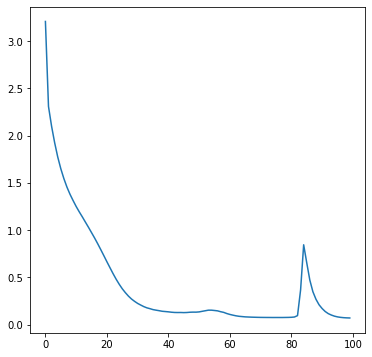

In [50]:
plt.figure(figsize = (6,6))
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.show()  

# Model Output

The following function will generate outputs from the model using the character mapping specified earlier.

In [51]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['', '[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

Pass the model and our character mappings into the class object.

In [52]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Lets produce some questions!

All we are doing is specifying a start set of characters (can be one letter, one word etc.), producing the next character and updating the state of the RNN. The new character and states are then passed into the RNN and so on until stopped.

In [54]:
start = time.time()
states = None
next_char = tf.constant(["what"])
result = [next_char]

for n in range(300): ##   Specify the number of characters to produce.
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

result_string = result[0].numpy().decode('utf-8')

print(result_string, '\n\n' + '_'*80)
print('\nRun time:', end - start)

what's the dumbest advice you've got from a relative?
i lost a dear friend today. what are some things that are better to be stupid about?
[serious] people who have multiple reddit accounts - why?
what is screwed up about the world but made you force your so or house in your neigned?
how do you justify  

________________________________________________________________________________

Run time: 0.6240875720977783


Those are some pretty real looking words! This AI has learnt how to spell words from scratch! However, some of the questions don't made great deal of sense.

Some of these questions look a bit too-well put-together so we will use the leu score to compare our specified question with all of our input questions and display the closest matching question.

Each of the output strings are actually one big string but the print statement doesn't dsiplay the `\n` so they appear to be seperate. Lets seperate out the output questions.

In [55]:
result_string = result_string.split('\n')

Specify the output line you want to test (indexing from 0).

In [56]:
test_result = result_string[0]
print(test_result)

what's the dumbest advice you've got from a relative?


Let's compare!

In [64]:
raw_titles = [title.split() for title in askreddit['raw_title']]
bleus = [sentence_bleu([raw_titles[i]], test_result.split()) for i in range(len(raw_titles))]
max_id = bleus.index(max(bleus))

print('_'*50)
print('\n\n')
print('Model Output  : {}'.format(test_result))
print('Closest Title : {}'.format(askreddit['raw_title'].iloc[max_id]))
print('\n\n')
print('_'*50)

__________________________________________________



Model Output  : what's the dumbest advice you've got from a relative?
Closest Title : what's the dumbest advice you've got from a relative?



__________________________________________________


In this case, the model has overfitted and produced a question that already exists withing the training dataset. This is generally the case for the first line generated.

Try seeding the model with different words or even phrases like 'how'.

Some questions also appear to make too much sense but don't match up with existing questions. It's worth searching some key words within the dataset to see if any questions exist that are slight modifications of our output.

In [65]:
def search_word(df, word):
  for i in range(len(df)):
    if word in df['raw_title'].iloc[i]:
      print(df['raw_title'].iloc[i])

In [67]:
search_word(askreddit, 'dummest')

what is the dummest thing you did on reddit?
